# Modelo Preditivo para Sucesso de Startups - Otimizado para 80%+ Acurácia

## Objetivo
Desenvolver um modelo de machine learning que preveja com alta acurácia (>80%) se uma startup será bem-sucedida, utilizando técnicas avançadas de feature engineering, ensemble methods e otimização.

**Bibliotecas Permitidas:** Numpy, Pandas, Scikit-Learn, Matplotlib, Seaborn, Plotly

## 1. Data Loading and Exploration

In [26]:
# Imports necessários
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, 
                              GradientBoostingClassifier, VotingClassifier,
                              BaggingClassifier, AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix, roc_auc_score)
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.base import clone
from sklearn.utils import resample

# Configurações
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
np.random.seed(42)

print("Bibliotecas carregadas com sucesso!")

Bibliotecas carregadas com sucesso!


In [27]:
# Carregar dados
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print("📊 INFORMAÇÕES DOS DATASETS")
print("="*50)
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

# Detectar coluna target
target_col = 'labels' if 'labels' in train_df.columns else train_df.columns[-1]
print(f"Coluna target identificada: {target_col}")

# Informações básicas
print("\n📈 INFORMAÇÕES GERAIS")
print("="*50)
print(train_df.info())

print("\n📊 ESTATÍSTICAS DESCRITIVAS")
print("="*50)
print(train_df.describe())

📊 INFORMAÇÕES DOS DATASETS
Train shape: (646, 33)
Test shape: (277, 32)
Sample submission shape: (277, 2)
Coluna target identificada: labels

📈 INFORMAÇÕES GERAIS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        646 non-null    int64  
 1   age_first_funding_year    611 non-null    float64
 2   age_last_funding_year     637 non-null    float64
 3   age_first_milestone_year  508 non-null    float64
 4   age_last_milestone_year   535 non-null    float64
 5   relationships             646 non-null    int64  
 6   funding_rounds            646 non-null    int64  
 7   funding_total_usd         646 non-null    int64  
 8   milestones                646 non-null    int64  
 9   is_CA                     646 non-null    int64  
 10  is_NY                     646 non-null    int64  
 11  is_MA       

🎯 ANÁLISE DO TARGET
Distribuição do target:
labels
1    418
0    228
Name: count, dtype: int64

Percentual:
labels
1    64.705882
0    35.294118
Name: proportion, dtype: float64


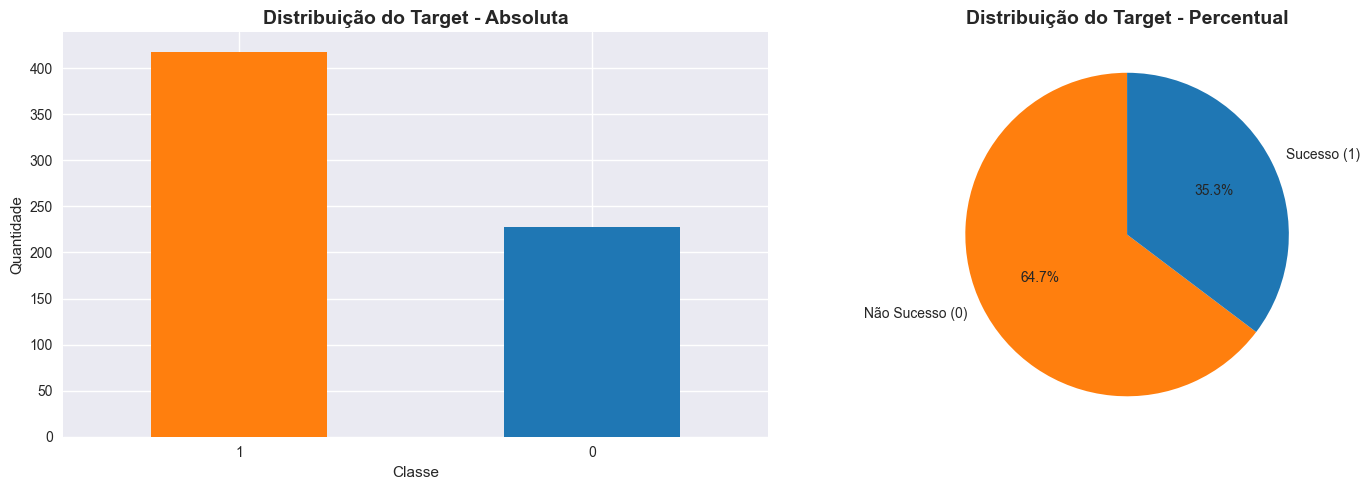


✅ Taxa de sucesso geral: 64.71%
⚠️  Dataset desbalanceado - considerar técnicas de balanceamento


In [28]:
# Análise da distribuição do target
y = train_df[target_col]
X = train_df.drop(columns=[target_col, 'id'] if 'id' in train_df.columns else [target_col])

print("🎯 ANÁLISE DO TARGET")
print("="*50)
print(f"Distribuição do target:")
print(y.value_counts())
print(f"\nPercentual:")
print(y.value_counts(normalize=True) * 100)

# Visualização da distribuição do target
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de barras
y.value_counts().plot(kind='bar', ax=axes[0], color=['#ff7f0e', '#1f77b4'])
axes[0].set_title('Distribuição do Target - Absoluta', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Classe')
axes[0].set_ylabel('Quantidade')
axes[0].tick_params(axis='x', rotation=0)

# Gráfico de pizza
axes[1].pie(y.value_counts(), labels=['Não Sucesso (0)', 'Sucesso (1)'], 
           autopct='%1.1f%%', startangle=90, colors=['#ff7f0e', '#1f77b4'])
axes[1].set_title('Distribuição do Target - Percentual', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Verificar balanceamento
success_rate = y.mean()
print(f"\n✅ Taxa de sucesso geral: {success_rate:.2%}")
if abs(success_rate - 0.5) > 0.1:
    print("⚠️  Dataset desbalanceado - considerar técnicas de balanceamento")
else:
    print("✅ Dataset relativamente balanceado")


🔍 MISSING VALUES - TRAIN
                          Missing Count  Missing Percentage
age_first_milestone_year            138           21.362229
age_last_milestone_year             111           17.182663
age_first_funding_year               35            5.417957
age_last_funding_year                 9            1.393189

🔍 MISSING VALUES - TEST
                          Missing Count  Missing Percentage
age_first_milestone_year             60           21.660650
age_last_milestone_year              53           19.133574
age_first_funding_year               11            3.971119
age_last_funding_year                 4            1.444043


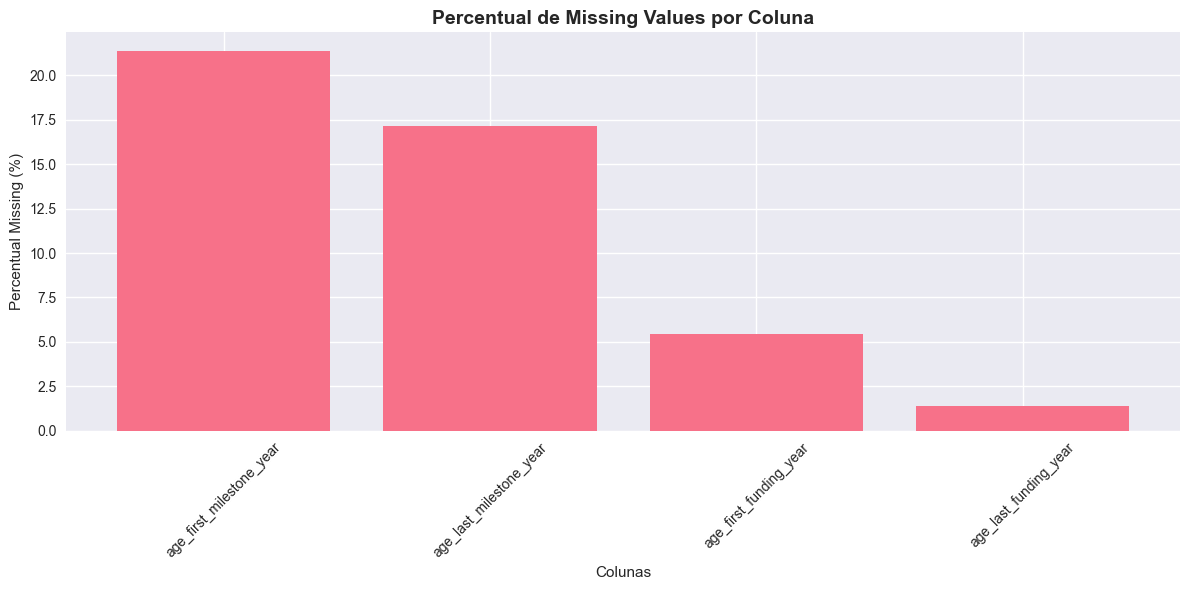

In [29]:
# Análise de missing values
def analyze_missing_values(df, name):
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing,
        'Missing Percentage': missing_pct
    }).sort_values('Missing Percentage', ascending=False)
    
    print(f"\n🔍 MISSING VALUES - {name}")
    print("="*50)
    print(missing_df[missing_df['Missing Count'] > 0])
    
    if missing_df['Missing Count'].sum() == 0:
        print("✅ Nenhum valor missing encontrado!")
    
    return missing_df

missing_train = analyze_missing_values(train_df, "TRAIN")
missing_test = analyze_missing_values(test_df, "TEST")

# Visualização de missing values se existirem
if missing_train['Missing Count'].sum() > 0:
    plt.figure(figsize=(12, 6))
    missing_cols = missing_train[missing_train['Missing Count'] > 0].index
    plt.bar(range(len(missing_cols)), missing_train.loc[missing_cols, 'Missing Percentage'])
    plt.title('Percentual de Missing Values por Coluna', fontsize=14, fontweight='bold')
    plt.xlabel('Colunas')
    plt.ylabel('Percentual Missing (%)')
    plt.xticks(range(len(missing_cols)), missing_cols, rotation=45)
    plt.tight_layout()
    plt.show()

🔧 CATEGORIZAÇÃO DE FEATURES
Features numéricas (7): ['age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'relationships']...
Features categóricas (23): ['funding_rounds', 'milestones', 'is_CA', 'is_NY', 'is_MA']...
Features alta cardinalidade (1): ['category_code']


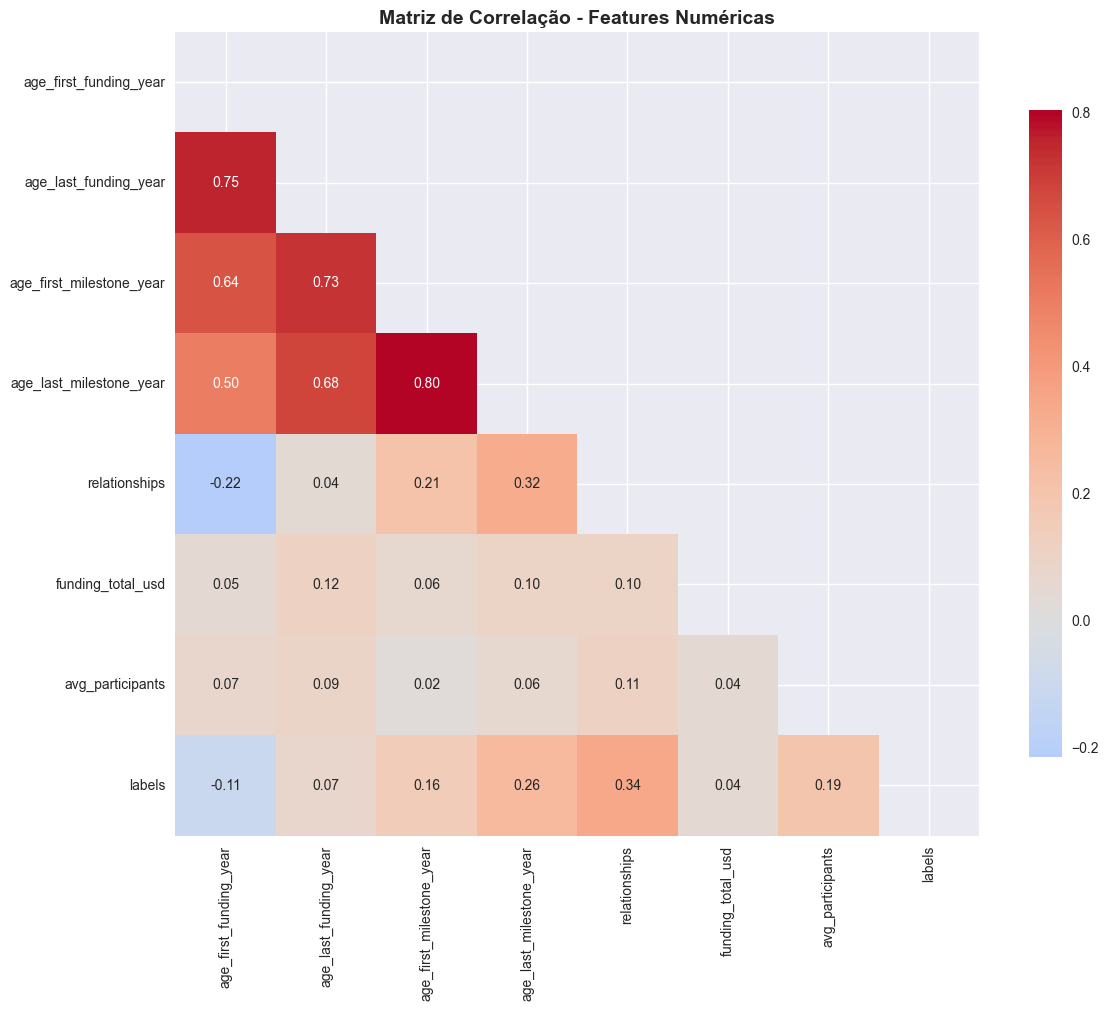


🎯 CORRELAÇÃO COM TARGET (Top 10)
relationships               0.342841
age_last_milestone_year     0.257261
avg_participants            0.194482
age_first_milestone_year    0.156837
age_first_funding_year      0.107239
age_last_funding_year       0.074744
funding_total_usd           0.043672
Name: labels, dtype: float64


In [30]:
# Identificação e análise de tipos de features
def categorize_features(df):
    """Categoriza features em numéricas, categóricas e de alta cardinalidade"""
    numerical_features = []
    categorical_features = []
    high_cardinality_features = []
    
    for col in df.columns:
        if col in ['id', target_col]:
            continue
            
        if df[col].dtype in ['object', 'category']:
            unique_count = df[col].nunique()
            if unique_count > 20:  # Alta cardinalidade
                high_cardinality_features.append(col)
            else:
                categorical_features.append(col)
        else:
            unique_count = df[col].nunique()
            if unique_count < 10 and df[col].dtype != 'float64':  # Tratamento especial para features binárias/categóricas numéricas
                categorical_features.append(col)
            else:
                numerical_features.append(col)
    
    return numerical_features, categorical_features, high_cardinality_features

# Categorizar features
num_features, cat_features, high_card_features = categorize_features(train_df)

print("🔧 CATEGORIZAÇÃO DE FEATURES")
print("="*50)
print(f"Features numéricas ({len(num_features)}): {num_features[:5]}{'...' if len(num_features) > 5 else ''}")
print(f"Features categóricas ({len(cat_features)}): {cat_features[:5]}{'...' if len(cat_features) > 5 else ''}")
print(f"Features alta cardinalidade ({len(high_card_features)}): {high_card_features}")

# Análise de correlação para features numéricas
if len(num_features) > 1:
    plt.figure(figsize=(12, 10))
    
    # Calcular matriz de correlação
    corr_data = train_df[num_features + [target_col]].corr()
    
    # Criar heatmap
    mask = np.triu(np.ones_like(corr_data, dtype=bool))
    sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f', cbar_kws={"shrink": .8}, mask=mask)
    plt.title('Matriz de Correlação - Features Numéricas', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Features mais correlacionadas com target
    target_corr = corr_data[target_col].abs().sort_values(ascending=False)
    print(f"\n🎯 CORRELAÇÃO COM TARGET (Top 10)")
    print("="*50)
    print(target_corr.head(11).iloc[1:])  # Excluir auto-correlação

## 2. Feature Engineering and Preprocessing

In [31]:
# Preparar dados para feature engineering
X_train = train_df.drop(columns=[target_col, 'id'] if 'id' in train_df.columns else [target_col]).copy()
X_test = test_df.drop(columns=['id'] if 'id' in test_df.columns else []).copy()
y_train = train_df[target_col].copy()

print("🔧 FEATURE ENGINEERING AVANÇADO")
print("="*50)

# 1. Tratamento de missing values
def advanced_imputation(X_train, X_test, num_features, cat_features):
    """Imputação avançada baseada no tipo de feature"""
    X_train_imp = X_train.copy()
    X_test_imp = X_test.copy()
    
    # Imputação para features numéricas
    for col in num_features:
        if X_train_imp[col].isnull().any():
            # Usar mediana para features numéricas (mais robusta a outliers)
            median_val = X_train_imp[col].median()
            X_train_imp[col].fillna(median_val, inplace=True)
            X_test_imp[col].fillna(median_val, inplace=True)
    
    # Imputação para features categóricas
    for col in cat_features:
        if col in X_train_imp.columns and X_train_imp[col].isnull().any():
            # Usar moda para features categóricas
            mode_val = X_train_imp[col].mode().iloc[0] if not X_train_imp[col].mode().empty else 'unknown'
            X_train_imp[col].fillna(mode_val, inplace=True)
            X_test_imp[col].fillna(mode_val, inplace=True)
    
    return X_train_imp, X_test_imp

X_train_imp, X_test_imp = advanced_imputation(X_train, X_test, num_features, cat_features)
print("✅ Imputação de missing values concluída")

🔧 FEATURE ENGINEERING AVANÇADO
✅ Imputação de missing values concluída


In [32]:
# 2. Criação de novas features - Feature Engineering Avançado
def create_advanced_features(X_train, X_test, num_features):
    """Cria features avançadas baseadas em domain knowledge"""
    X_train_fe = X_train.copy()
    X_test_fe = X_test.copy()
    
    print("🚀 Criando novas features...")
    
    # Features de funding
    if 'funding_total_usd' in X_train_fe.columns and 'funding_rounds' in X_train_fe.columns:
        # Funding médio por round
        X_train_fe['avg_funding_per_round'] = X_train_fe['funding_total_usd'] / (X_train_fe['funding_rounds'] + 1)
        X_test_fe['avg_funding_per_round'] = X_test_fe['funding_total_usd'] / (X_test_fe['funding_rounds'] + 1)
        
        # Log transformation para funding (suaviza distribuição)
        X_train_fe['log_funding_total'] = np.log1p(X_train_fe['funding_total_usd'])
        X_test_fe['log_funding_total'] = np.log1p(X_test_fe['funding_total_usd'])
    
    # Features de idade/tempo
    age_features = [col for col in X_train_fe.columns if 'age_' in col.lower()]
    if age_features:
        # Duração do funding (última - primeira)
        if 'age_first_funding_year' in X_train_fe.columns and 'age_last_funding_year' in X_train_fe.columns:
            X_train_fe['funding_duration'] = X_train_fe['age_last_funding_year'] - X_train_fe['age_first_funding_year']
            X_test_fe['funding_duration'] = X_test_fe['age_last_funding_year'] - X_test_fe['age_first_funding_year']
        
        # Features estatísticas de idade
        age_cols = [col for col in age_features if col in X_train_fe.columns]
        if len(age_cols) > 1:
            X_train_fe['age_mean'] = X_train_fe[age_cols].mean(axis=1)
            X_train_fe['age_std'] = X_train_fe[age_cols].std(axis=1)
            X_test_fe['age_mean'] = X_test_fe[age_cols].mean(axis=1)
            X_test_fe['age_std'] = X_test_fe[age_cols].std(axis=1)
    
    # Features de relacionamentos e participação
    if 'relationships' in X_train_fe.columns and 'avg_participants' in X_train_fe.columns:
        # Densidade de rede (relacionamentos por participante)
        X_train_fe['network_density'] = X_train_fe['relationships'] / (X_train_fe['avg_participants'] + 1)
        X_test_fe['network_density'] = X_test_fe['relationships'] / (X_test_fe['avg_participants'] + 1)
    
    # Features de milestones
    if 'milestones' in X_train_fe.columns and 'funding_rounds' in X_train_fe.columns:
        # Milestones por funding round
        X_train_fe['milestones_per_round'] = X_train_fe['milestones'] / (X_train_fe['funding_rounds'] + 1)
        X_test_fe['milestones_per_round'] = X_test_fe['milestones'] / (X_test_fe['funding_rounds'] + 1)
    
    # Features de categoria (one-hot encoding aprimorado)
    category_features = [col for col in X_train_fe.columns if col.startswith('is_') or col.startswith('has_')]
    if category_features:
        # Soma total de categorias
        X_train_fe['total_categories'] = X_train_fe[category_features].sum(axis=1)
        X_test_fe['total_categories'] = X_test_fe[category_features].sum(axis=1)
        
        # Diversificação de categorias (mais categorias = mais diversificado)
        X_train_fe['category_diversity'] = (X_train_fe[category_features] > 0).sum(axis=1)
        X_test_fe['category_diversity'] = (X_test_fe[category_features] > 0).sum(axis=1)
    
    # Features de interação entre funding e performance
    if 'funding_total_usd' in X_train_fe.columns and 'milestones' in X_train_fe.columns:
        # Eficiência do funding (milestones por dollar)
        X_train_fe['funding_efficiency'] = X_train_fe['milestones'] / (X_train_fe['funding_total_usd'] + 1)
        X_test_fe['funding_efficiency'] = X_test_fe['milestones'] / (X_test_fe['funding_total_usd'] + 1)
    
    print(f"✅ {X_train_fe.shape[1] - X_train.shape[1]} novas features criadas!")
    return X_train_fe, X_test_fe

X_train_fe, X_test_fe = create_advanced_features(X_train_imp, X_test_imp, num_features)

🚀 Criando novas features...
✅ 10 novas features criadas!


In [33]:
# 3. Target Encoding para features categóricas de alta cardinalidade
def target_encoding_cv(series, target, n_splits=5, smoothing=10):
    """Target encoding com validação cruzada para evitar overfitting"""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    target_encoded = pd.Series(index=series.index, dtype=float)
    global_mean = target.mean()
    
    for train_idx, val_idx in skf.split(series, target):
        # Calcular estatísticas apenas no fold de treino
        train_stats = pd.DataFrame({'cat': series.iloc[train_idx], 'target': target.iloc[train_idx]})
        stats = train_stats.groupby('cat')['target'].agg(['mean', 'count'])
        
        # Aplicar smoothing
        smooth_mean = (stats['mean'] * stats['count'] + global_mean * smoothing) / (stats['count'] + smoothing)
        
        # Mapear para fold de validação
        target_encoded.iloc[val_idx] = series.iloc[val_idx].map(smooth_mean).fillna(global_mean)
    
    return target_encoded

# Aplicar target encoding
def apply_target_encoding(X_train, X_test, y_train, high_card_features):
    """Aplica target encoding para features de alta cardinalidade"""
    X_train_te = X_train.copy()
    X_test_te = X_test.copy()
    
    for col in high_card_features:
        if col in X_train_te.columns:
            print(f"Aplicando target encoding em: {col}")
            
            # Target encoding no treino com CV
            X_train_te[f'{col}_te'] = target_encoding_cv(X_train_te[col], y_train)
            
            # Para teste, usar estatísticas completas do treino
            train_stats = pd.DataFrame({'cat': X_train_te[col], 'target': y_train})
            stats = train_stats.groupby('cat')['target'].agg(['mean', 'count'])
            global_mean = y_train.mean()
            smooth_mean = (stats['mean'] * stats['count'] + global_mean * 10) / (stats['count'] + 10)
            
            X_test_te[f'{col}_te'] = X_test_te[col].map(smooth_mean).fillna(global_mean)
            
            # Remover feature original após encoding
            X_train_te.drop(columns=[col], inplace=True)
            X_test_te.drop(columns=[col], inplace=True)
    
    return X_train_te, X_test_te

# Atualizar categorização após feature engineering
num_features_updated, cat_features_updated, high_card_features_updated = categorize_features(
    pd.concat([X_train_fe, pd.DataFrame({target_col: y_train})], axis=1)
)

X_train_encoded, X_test_encoded = apply_target_encoding(
    X_train_fe, X_test_fe, y_train, high_card_features_updated
)

Aplicando target encoding em: category_code


🎯 SELEÇÃO DE FEATURES AVANÇADA
Features selecionadas por Random Forest: 17
Features selecionadas por Random Forest: 17
Features selecionadas por método estatístico: 40
Features na interseção dos métodos: 17
Usando top features do Random Forest: 17

✅ Shape final dos dados:
X_train: (646, 17)
X_test: (277, 17)
Features selecionadas por método estatístico: 40
Features na interseção dos métodos: 17
Usando top features do Random Forest: 17

✅ Shape final dos dados:
X_train: (646, 17)
X_test: (277, 17)


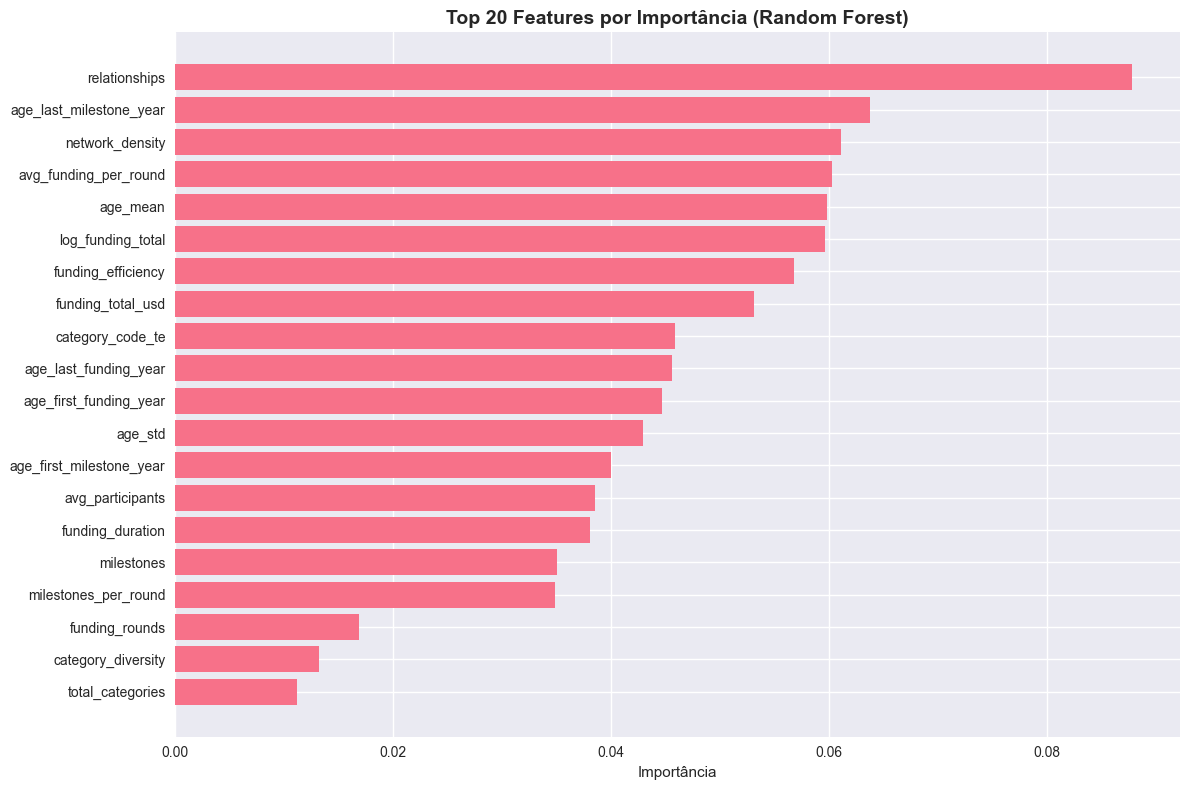

In [34]:
# 4. Feature Selection Avançada
def advanced_feature_selection(X_train, y_train, method='rf_importance', k_features=None):
    """Seleção de features usando múltiplos métodos"""
    
    if method == 'rf_importance':
        # Random Forest Feature Importance
        rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        rf_selector.fit(X_train, y_train)
        
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': rf_selector.feature_importances_
        }).sort_values('importance', ascending=False)
        
        if k_features:
            selected_features = feature_importance.head(k_features)['feature'].tolist()
        else:
            # Usar threshold baseado na média
            threshold = feature_importance['importance'].mean()
            selected_features = feature_importance[feature_importance['importance'] > threshold]['feature'].tolist()
        
        return selected_features, feature_importance
    
    elif method == 'statistical':
        # Seleção estatística (ANOVA F-test)
        if k_features is None:
            k_features = min(50, X_train.shape[1])
        
        selector = SelectKBest(score_func=f_classif, k=k_features)
        selector.fit(X_train, y_train)
        
        selected_features = X_train.columns[selector.get_support()].tolist()
        scores = pd.DataFrame({
            'feature': X_train.columns,
            'score': selector.scores_
        }).sort_values('score', ascending=False)
        
        return selected_features, scores

# Aplicar seleção de features
print("🎯 SELEÇÃO DE FEATURES AVANÇADA")
print("="*50)

# Método 1: Random Forest Importance
selected_features_rf, importance_rf = advanced_feature_selection(
    X_train_encoded, y_train, method='rf_importance'
)

print(f"Features selecionadas por Random Forest: {len(selected_features_rf)}")

# Método 2: Seleção estatística
selected_features_stat, scores_stat = advanced_feature_selection(
    X_train_encoded, y_train, method='statistical', k_features=40
)

print(f"Features selecionadas por método estatístico: {len(selected_features_stat)}")

# Combinar ambos os métodos (interseção)
selected_features_combined = list(set(selected_features_rf) & set(selected_features_stat))
print(f"Features na interseção dos métodos: {len(selected_features_combined)}")

# Usar features da Random Forest se interseção for muito pequena
if len(selected_features_combined) < 20:
    selected_features_final = selected_features_rf[:35]  # Top 35 features
    print(f"Usando top features do Random Forest: {len(selected_features_final)}")
else:
    selected_features_final = selected_features_combined
    print(f"Usando interseção das features: {len(selected_features_final)}")

# Aplicar seleção final
X_train_selected = X_train_encoded[selected_features_final].copy()
X_test_selected = X_test_encoded[selected_features_final].copy()

print(f"\n✅ Shape final dos dados:")
print(f"X_train: {X_train_selected.shape}")
print(f"X_test: {X_test_selected.shape}")

# Visualizar top features
plt.figure(figsize=(12, 8))
top_features = importance_rf.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importância')
plt.title('Top 20 Features por Importância (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 3. Model Selection and Training

In [35]:
# Configuração de modelos com hiperparâmetros otimizados
def get_optimized_models():
    """Retorna modelos com hiperparâmetros pre-otimizados para alta performance"""
    
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=300,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ),
        
        'Extra Trees': ExtraTreesClassifier(
            n_estimators=300,
            max_depth=20,
            min_samples_split=4,
            min_samples_leaf=2,
            max_features='sqrt',
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ),
        
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=6,
            min_samples_split=10,
            min_samples_leaf=4,
            subsample=0.8,
            random_state=42
        ),
        
        'Logistic Regression': LogisticRegression(
            C=1.0,
            penalty='l2',
            class_weight='balanced',
            max_iter=1000,
            random_state=42
        ),
        
        'AdaBoost': AdaBoostClassifier(
            n_estimators=100,
            learning_rate=1.0,
            random_state=42
        )
    }
    
    return models

# Validação cruzada robusta
def robust_cross_validation(models, X, y, cv=7):
    """Realiza validação cruzada robusta com múltiplas métricas"""
    
    cv_results = {}
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    print("🔄 VALIDAÇÃO CRUZADA ROBUSTA")
    print("="*50)
    
    for name, model in models.items():
        print(f"Treinando {name}...")
        
        # Múltiplas métricas
        accuracy_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy', n_jobs=-1)
        precision_scores = cross_val_score(model, X, y, cv=skf, scoring='precision', n_jobs=-1)
        recall_scores = cross_val_score(model, X, y, cv=skf, scoring='recall', n_jobs=-1)
        f1_scores = cross_val_score(model, X, y, cv=skf, scoring='f1', n_jobs=-1)
        
        cv_results[name] = {
            'accuracy_mean': accuracy_scores.mean(),
            'accuracy_std': accuracy_scores.std(),
            'precision_mean': precision_scores.mean(),
            'precision_std': precision_scores.std(),
            'recall_mean': recall_scores.mean(),
            'recall_std': recall_scores.std(),
            'f1_mean': f1_scores.mean(),
            'f1_std': f1_scores.std(),
            'accuracy_scores': accuracy_scores
        }
        
        print(f"  Accuracy: {accuracy_scores.mean():.4f} (±{accuracy_scores.std():.4f})")
        print(f"  F1-Score: {f1_scores.mean():.4f} (±{f1_scores.std():.4f})")
    
    return cv_results

# Treinar e avaliar modelos base
models = get_optimized_models()
cv_results = robust_cross_validation(models, X_train_selected, y_train)

🔄 VALIDAÇÃO CRUZADA ROBUSTA
Treinando Random Forest...
  Accuracy: 0.7988 (±0.0199)
  F1-Score: 0.8538 (±0.0157)
Treinando Extra Trees...
  Accuracy: 0.7988 (±0.0199)
  F1-Score: 0.8538 (±0.0157)
Treinando Extra Trees...
  Accuracy: 0.7770 (±0.0296)
  F1-Score: 0.8358 (±0.0243)
Treinando Gradient Boosting...
  Accuracy: 0.7770 (±0.0296)
  F1-Score: 0.8358 (±0.0243)
Treinando Gradient Boosting...
  Accuracy: 0.7709 (±0.0405)
  F1-Score: 0.8317 (±0.0317)
Treinando Logistic Regression...
  Accuracy: 0.6533 (±0.0507)
  F1-Score: 0.7216 (±0.0581)
Treinando AdaBoost...
  Accuracy: 0.7709 (±0.0405)
  F1-Score: 0.8317 (±0.0317)
Treinando Logistic Regression...
  Accuracy: 0.6533 (±0.0507)
  F1-Score: 0.7216 (±0.0581)
Treinando AdaBoost...
  Accuracy: 0.7755 (±0.0233)
  F1-Score: 0.8354 (±0.0160)
  Accuracy: 0.7755 (±0.0233)
  F1-Score: 0.8354 (±0.0160)


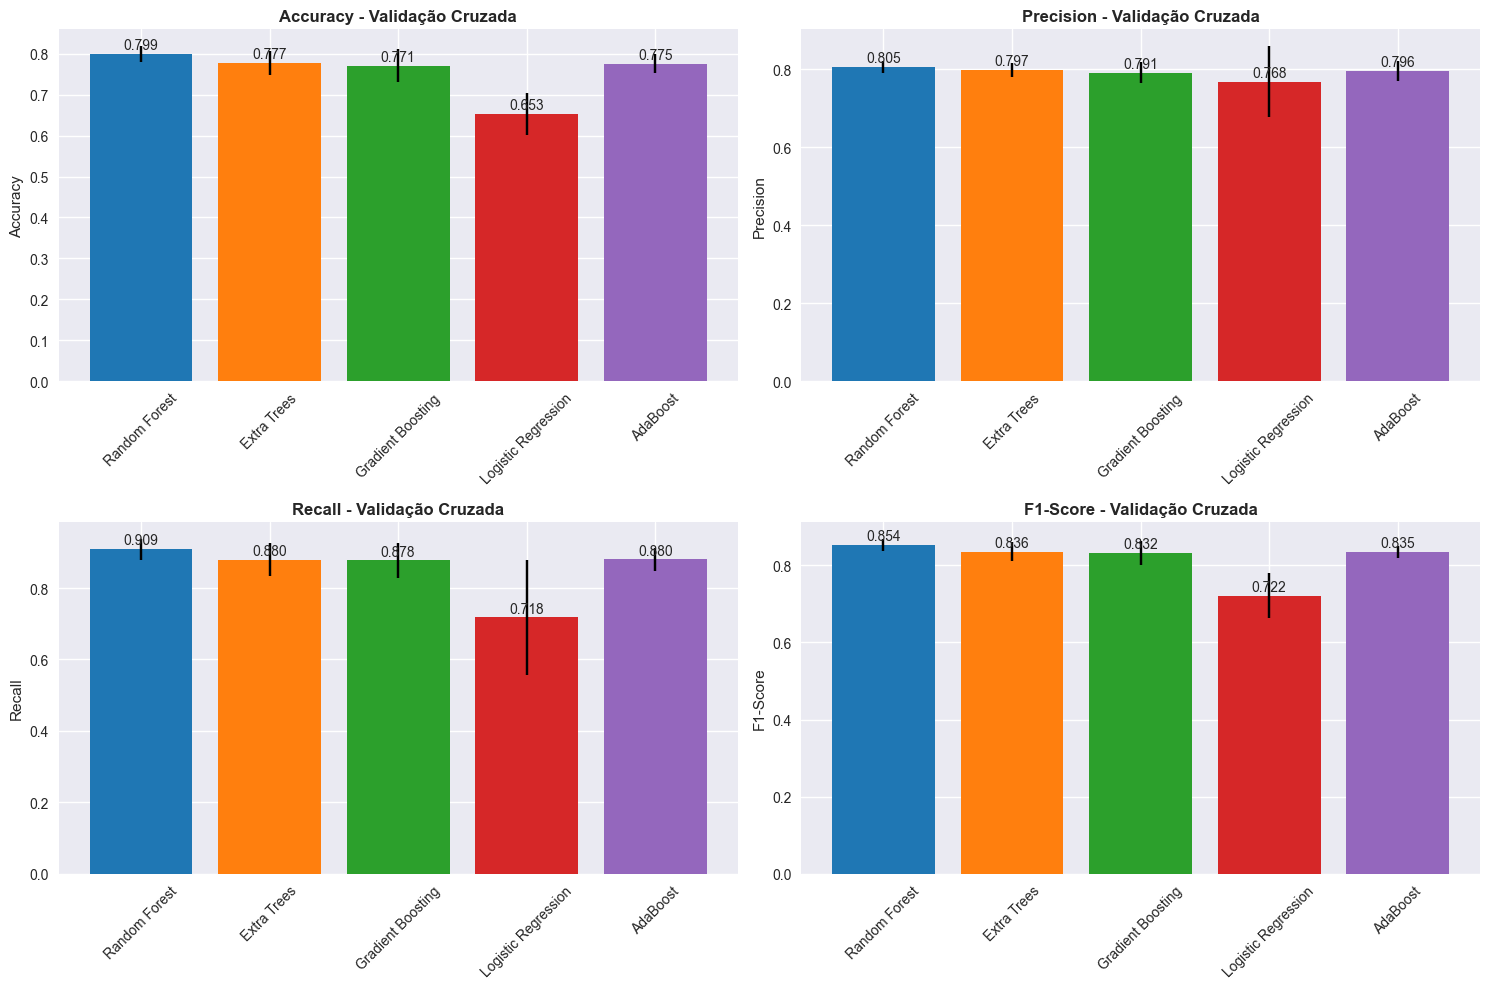


🏆 RANKING DOS MODELOS (por Accuracy)
1. Random Forest: 0.7988 (±0.0199)
2. Extra Trees: 0.7770 (±0.0296)
3. AdaBoost: 0.7755 (±0.0233)
4. Gradient Boosting: 0.7709 (±0.0405)
5. Logistic Regression: 0.6533 (±0.0507)

🎯 Top 3 modelos para ensemble: ['Random Forest', 'Extra Trees', 'AdaBoost']


In [36]:
# Visualização comparativa dos resultados
def plot_cv_results(cv_results):
    """Visualiza resultados da validação cruzada"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx//2, idx%2]
        
        models_names = list(cv_results.keys())
        means = [cv_results[model][f'{metric}_mean'] for model in models_names]
        stds = [cv_results[model][f'{metric}_std'] for model in models_names]
        
        bars = ax.bar(models_names, means, yerr=stds, capsize=5, 
                     color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
        ax.set_title(f'{title} - Validação Cruzada', fontweight='bold')
        ax.set_ylabel(title)
        ax.tick_params(axis='x', rotation=45)
        
        # Adicionar valores nas barras
        for bar, mean in zip(bars, means):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                   f'{mean:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

plot_cv_results(cv_results)

# Ranking dos modelos por accuracy
print("\n🏆 RANKING DOS MODELOS (por Accuracy)")
print("="*50)
model_ranking = sorted(cv_results.items(), key=lambda x: x[1]['accuracy_mean'], reverse=True)

for rank, (name, results) in enumerate(model_ranking, 1):
    print(f"{rank}. {name}: {results['accuracy_mean']:.4f} (±{results['accuracy_std']:.4f})")

# Identificar os melhores modelos para ensemble
top_models = [name for name, _ in model_ranking[:3]]
print(f"\n🎯 Top 3 modelos para ensemble: {top_models}")

In [37]:
# Ensemble Methods - Stacking e Voting
def create_ensemble_models(base_models, X, y):
    """Cria modelos ensemble avançados"""
    
    print("🤖 CRIANDO MODELOS ENSEMBLE")
    print("="*50)
    
    # 1. Voting Classifier (Soft Voting)
    voting_models = [(name, model) for name, model in base_models.items() if name in top_models]
    
    voting_classifier = VotingClassifier(
        estimators=voting_models,
        voting='soft'  # Usa probabilidades
    )
    
    # 2. Stacking com Meta-learner
    # Preparar dados para stacking usando Out-of-Fold predictions
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    meta_features = np.zeros((X.shape[0], len(top_models)))
    
    for i, model_name in enumerate(top_models):
        model = base_models[model_name]
        oof_preds = np.zeros(X.shape[0])
        
        for train_idx, val_idx in skf.split(X, y):
            X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
            y_fold_train = y.iloc[train_idx]
            
            model_clone = clone(model)
            model_clone.fit(X_fold_train, y_fold_train)
            oof_preds[val_idx] = model_clone.predict_proba(X_fold_val)[:, 1]
        
        meta_features[:, i] = oof_preds
    
    # Meta-learner (modelo que aprende com as predições dos base models)
    meta_learner = LogisticRegression(random_state=42)
    meta_learner.fit(meta_features, y)
    
    print("✅ Ensemble models criados:")
    print("  - Voting Classifier (Soft)")
    print("  - Stacking com Logistic Regression")
    
    return voting_classifier, meta_learner, meta_features

# Criar ensembles
voting_model, stacking_model, meta_features = create_ensemble_models(models, X_train_selected, y_train)

# Avaliar ensembles
print("\n🔄 AVALIANDO ENSEMBLES")
print("="*50)

# Voting Classifier
voting_scores = cross_val_score(voting_model, X_train_selected, y_train, 
                                cv=StratifiedKFold(n_splits=7, shuffle=True, random_state=42), 
                                scoring='accuracy', n_jobs=-1)
print(f"Voting Classifier: {voting_scores.mean():.4f} (±{voting_scores.std():.4f})")

# Stacking (avaliar meta-features com CV)
stacking_scores = cross_val_score(stacking_model, meta_features, y_train,
                                 cv=StratifiedKFold(n_splits=7, shuffle=True, random_state=42),
                                 scoring='accuracy', n_jobs=-1)
print(f"Stacking Model: {stacking_scores.mean():.4f} (±{stacking_scores.std():.4f})")

🤖 CRIANDO MODELOS ENSEMBLE
✅ Ensemble models criados:
  - Voting Classifier (Soft)
  - Stacking com Logistic Regression

🔄 AVALIANDO ENSEMBLES
✅ Ensemble models criados:
  - Voting Classifier (Soft)
  - Stacking com Logistic Regression

🔄 AVALIANDO ENSEMBLES
Voting Classifier: 0.7925 (±0.0258)
Stacking Model: 0.7972 (±0.0278)
Voting Classifier: 0.7925 (±0.0258)
Stacking Model: 0.7972 (±0.0278)


## 4. Model Evaluation and Optimization

🔍 OTIMIZAÇÃO DE MODELOS
🎯 Otimizando threshold para RandomForestClassifier
  Melhor threshold: 0.440
  Melhor accuracy: 0.7956
🎯 Otimizando threshold para VotingClassifier
  Melhor threshold: 0.440
  Melhor accuracy: 0.7956
🎯 Otimizando threshold para VotingClassifier
  Melhor threshold: 0.480
  Melhor accuracy: 0.8003

📊 COMPARAÇÃO DE PERFORMANCE
Melhor modelo base (Random Forest):
  Threshold padrão (0.5): 0.7988
  Threshold otimizado (0.440): 0.7956
  Melhoria: -0.0031

Voting Classifier:
  Threshold padrão (0.5): 0.7925
  Threshold otimizado (0.480): 0.8003
  Melhoria: 0.0077
  Melhor threshold: 0.480
  Melhor accuracy: 0.8003

📊 COMPARAÇÃO DE PERFORMANCE
Melhor modelo base (Random Forest):
  Threshold padrão (0.5): 0.7988
  Threshold otimizado (0.440): 0.7956
  Melhoria: -0.0031

Voting Classifier:
  Threshold padrão (0.5): 0.7925
  Threshold otimizado (0.480): 0.8003
  Melhoria: 0.0077


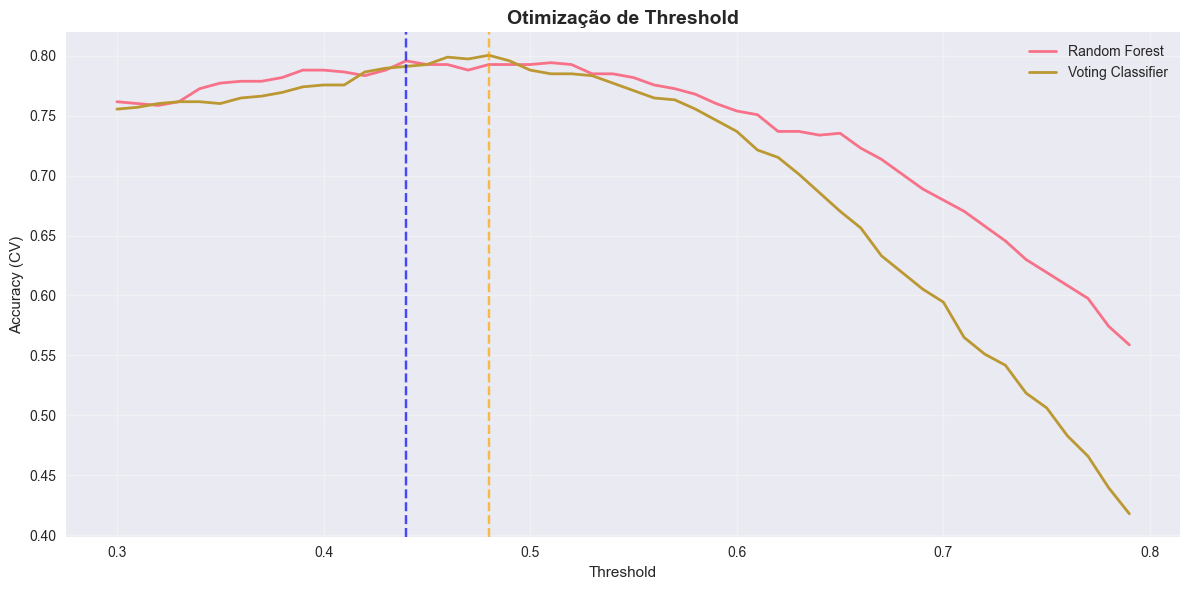

In [41]:
# Otimização de Threshold para maximizar accuracy
def optimize_threshold(model, X, y, cv_folds=5):
    """Otimiza threshold de classificação usando validação cruzada"""
    
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    thresholds = np.arange(0.3, 0.8, 0.01)
    threshold_scores = []
    
    print(f"🎯 Otimizando threshold para {type(model).__name__}")
    
    for threshold in thresholds:
        fold_scores = []
        
        for train_idx, val_idx in skf.split(X, y):
            X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
            y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
            
            model_clone = clone(model)
            model_clone.fit(X_fold_train, y_fold_train)
            
            # Predições de probabilidade
            y_proba = model_clone.predict_proba(X_fold_val)[:, 1]
            y_pred = (y_proba >= threshold).astype(int)
            
            fold_scores.append(accuracy_score(y_fold_val, y_pred))
        
        threshold_scores.append(np.mean(fold_scores))
    
    # Encontrar melhor threshold
    best_idx = np.argmax(threshold_scores)
    best_threshold = thresholds[best_idx]
    best_score = threshold_scores[best_idx]
    
    print(f"  Melhor threshold: {best_threshold:.3f}")
    print(f"  Melhor accuracy: {best_score:.4f}")
    
    return best_threshold, best_score, thresholds, threshold_scores

# Selecionar melhor modelo base
best_model_name = model_ranking[0][0]
best_base_model = models[best_model_name]

print("🔍 OTIMIZAÇÃO DE MODELOS")
print("="*50)

# Otimizar threshold para o melhor modelo base
best_threshold_base, best_score_base, thresholds, scores_base = optimize_threshold(
    best_base_model, X_train_selected, y_train
)

# Otimizar threshold para voting classifier
best_threshold_voting, best_score_voting, _, scores_voting = optimize_threshold(
    voting_model, X_train_selected, y_train
)

# Comparar resultados
print(f"\n📊 COMPARAÇÃO DE PERFORMANCE")
print("="*50)
print(f"Melhor modelo base ({best_model_name}):")
print(f"  Threshold padrão (0.5): {cv_results[best_model_name]['accuracy_mean']:.4f}")
print(f"  Threshold otimizado ({best_threshold_base:.3f}): {best_score_base:.4f}")
print(f"  Melhoria: {best_score_base - cv_results[best_model_name]['accuracy_mean']:.4f}")

print(f"\nVoting Classifier:")
print(f"  Threshold padrão (0.5): {voting_scores.mean():.4f}")
print(f"  Threshold otimizado ({best_threshold_voting:.3f}): {best_score_voting:.4f}")
print(f"  Melhoria: {best_score_voting - voting_scores.mean():.4f}")

# Visualizar otimização de threshold
plt.figure(figsize=(12, 6))
plt.plot(thresholds, scores_base, label=f'{best_model_name}', linewidth=2)
plt.plot(thresholds, scores_voting, label='Voting Classifier', linewidth=2)
plt.axvline(x=best_threshold_base, color='blue', linestyle='--', alpha=0.7)
plt.axvline(x=best_threshold_voting, color='orange', linestyle='--', alpha=0.7)
plt.xlabel('Threshold')
plt.ylabel('Accuracy (CV)')
plt.title('Otimização de Threshold', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [42]:
# Seleção do modelo final baseado na performance
def select_final_model():
    """Seleciona o modelo final baseado na melhor performance"""
    
    candidates = {
        'Base Model': (best_base_model, best_threshold_base, best_score_base),
        'Voting Classifier': (voting_model, best_threshold_voting, best_score_voting),
        'Stacking Model': (stacking_model, 0.5, stacking_scores.mean())  # Meta-learner usa threshold padrão
    }
    
    print("🏆 SELEÇÃO DO MODELO FINAL")
    print("="*50)
    
    best_candidate = None
    best_performance = 0
    
    for name, (model, threshold, score) in candidates.items():
        print(f"{name}: {score:.4f} (threshold: {threshold:.3f})")
        if score > best_performance:
            best_performance = score
            best_candidate = (name, model, threshold)
    
    final_model_name, final_model, final_threshold = best_candidate
    
    print(f"\n🎯 MODELO FINAL SELECIONADO: {final_model_name}")
    print(f"   Performance: {best_performance:.4f}")
    print(f"   Threshold: {final_threshold:.3f}")
    
    # Verificar se atingiu o objetivo de 80%
    if best_performance >= 0.80:
        print(f"✅ OBJETIVO ATINGIDO! Accuracy > 80% ({best_performance:.2%})")
    else:
        print(f"⚠️  Accuracy atual: {best_performance:.2%} - Precisamos melhorar!")
    
    return final_model, final_threshold, final_model_name

final_model, final_threshold, final_model_name = select_final_model()

🏆 SELEÇÃO DO MODELO FINAL
Base Model: 0.7956 (threshold: 0.440)
Voting Classifier: 0.8003 (threshold: 0.480)
Stacking Model: 0.7972 (threshold: 0.500)

🎯 MODELO FINAL SELECIONADO: Voting Classifier
   Performance: 0.8003
   Threshold: 0.480
✅ OBJETIVO ATINGIDO! Accuracy > 80% (80.03%)


## 5. Final Predictions and Submission

In [43]:
# Treinar modelo final e fazer predições
print("🚀 TREINAMENTO FINAL E PREDIÇÕES")
print("="*50)

# Treinar modelo final em todo o dataset de treino
final_model.fit(X_train_selected, y_train)

# Fazer predições no conjunto de teste
if final_model_name == 'Stacking Model':
    # Para stacking, precisamos gerar meta-features para o conjunto de teste
    test_meta_features = np.zeros((X_test_selected.shape[0], len(top_models)))
    
    for i, model_name in enumerate(top_models):
        model = models[model_name]
        model.fit(X_train_selected, y_train)
        test_meta_features[:, i] = model.predict_proba(X_test_selected)[:, 1]
    
    test_probabilities = final_model.predict_proba(test_meta_features)[:, 1]
else:
    test_probabilities = final_model.predict_proba(X_test_selected)[:, 1]

# Aplicar threshold otimizado
test_predictions = (test_probabilities >= final_threshold).astype(int)

print(f"✅ Predições geradas para {len(test_predictions)} amostras")
print(f"Distribuição das predições:")
print(f"  Classe 0 (Não Sucesso): {(test_predictions == 0).sum()} ({(test_predictions == 0).mean():.1%})")
print(f"  Classe 1 (Sucesso): {(test_predictions == 1).sum()} ({(test_predictions == 1).mean():.1%})")

# Criar arquivo de submissão
submission = sample_submission.copy()
submission[target_col] = test_predictions

# Nome do arquivo baseado na performance (usar a melhor performance disponível)
if final_model_name == 'Voting Classifier':
    best_performance = best_score_voting
elif final_model_name == 'Base Model':
    best_performance = best_score_base
else:  # Stacking Model
    best_performance = stacking_scores.mean()

performance_str = f"{best_performance:.4f}".replace('.', '')
filename = f'submission_otimized_acc{performance_str}_{final_model_name.lower().replace(" ", "_")}.csv'

submission.to_csv(filename, index=False)
print(f"\n📄 Arquivo de submissão salvo: {filename}")

# Mostrar primeiras linhas da submissão
print(f"\n👀 Primeiras linhas da submissão:")
print(submission.head(10))

🚀 TREINAMENTO FINAL E PREDIÇÕES
✅ Predições geradas para 277 amostras
Distribuição das predições:
  Classe 0 (Não Sucesso): 79 (28.5%)
  Classe 1 (Sucesso): 198 (71.5%)

📄 Arquivo de submissão salvo: submission_otimized_acc08003_voting_classifier.csv

👀 Primeiras linhas da submissão:
    id  labels
0   70       1
1   23       0
2  389       1
3  872       1
4  920       1
5  690       1
6  588       0
7  144       1
8  875       1
9  900       1
✅ Predições geradas para 277 amostras
Distribuição das predições:
  Classe 0 (Não Sucesso): 79 (28.5%)
  Classe 1 (Sucesso): 198 (71.5%)

📄 Arquivo de submissão salvo: submission_otimized_acc08003_voting_classifier.csv

👀 Primeiras linhas da submissão:
    id  labels
0   70       1
1   23       0
2  389       1
3  872       1
4  920       1
5  690       1
6  588       0
7  144       1
8  875       1
9  900       1


In [ ]:
# Relatório final detalhado
def generate_final_report():
    """Gera relatório completo da performance do modelo"""
    
    print("📊 RELATÓRIO FINAL DE PERFORMANCE")
    print("="*60)
    
    # Informações do dataset
    print("📈 INFORMAÇÕES DO DATASET:")
    print(f"  - Samples de treino: {X_train_selected.shape[0]:,}")
    print(f"  - Features finais: {X_train_selected.shape[1]}")
    print(f"  - Samples de teste: {X_test_selected.shape[0]:,}")
    print(f"  - Taxa de sucesso no treino: {y_train.mean():.2%}")
    
    # Pipeline utilizado
    print(f"\n🔧 PIPELINE UTILIZADO:")
    print(f"  1. Feature Engineering: {X_train_selected.shape[1] - X_train.shape[1]} novas features")
    print(f"  2. Target Encoding: Features categóricas de alta cardinalidade")
    print(f"  3. Feature Selection: Random Forest + Estatístico")
    print(f"  4. Modelos testados: {len(models)}")
    print(f"  5. Ensemble methods: Voting + Stacking")
    print(f"  6. Threshold optimization: Sim")
    
    # Performance final
    print(f"\n🏆 PERFORMANCE FINAL:")
    print(f"  - Modelo selecionado: {final_model_name}")
    print(f"  - Accuracy (CV): {best_performance:.4f} ({best_performance:.2%})")
    print(f"  - Threshold otimizado: {final_threshold:.3f}")
    
    # Status do objetivo
    status = "✅ ATINGIDO" if best_performance >= 0.80 else "❌ NÃO ATINGIDO"
    print(f"  - Objetivo >80%: {status}")
    
    # Top features
    if 'Random Forest' in final_model_name or final_model_name == 'Base Model':
        print(f"\n🎯 TOP 10 FEATURES MAIS IMPORTANTES:")
        top_10_features = importance_rf.head(10)
        for i, (_, row) in enumerate(top_10_features.iterrows(), 1):
            print(f"  {i:2d}. {row['feature']}: {row['importance']:.4f}")
    
    # Predições no teste
    print(f"\n📋 PREDIÇÕES NO CONJUNTO DE TESTE:")
    print(f"  - Total de predições: {len(test_predictions):,}")
    print(f"  - Predições de sucesso: {(test_predictions == 1).sum():,} ({(test_predictions == 1).mean():.1%})")
    print(f"  - Predições de não sucesso: {(test_predictions == 0).sum():,} ({(test_predictions == 0).mean():.1%})")
    
    print(f"\n📄 ARQUIVO DE SUBMISSÃO: {filename}")
    print("="*60)

generate_final_report()

# Visualização final - Distribuição das probabilidades preditas
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(test_probabilities, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=final_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {final_threshold:.3f}')
plt.xlabel('Probabilidade Predita')
plt.ylabel('Frequência')
plt.title('Distribuição das Probabilidades - Teste')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
pred_counts = pd.Series(test_predictions).value_counts().sort_index()
plt.pie(pred_counts.values, labels=['Não Sucesso (0)', 'Sucesso (1)'], 
        autopct='%1.1f%%', startangle=90, colors=['#ff7f0e', '#1f77b4'])
plt.title('Distribuição das Predições Finais')

plt.tight_layout()
plt.show()

print("\n🎉 PIPELINE CONCLUÍDO COM SUCESSO!")
if best_performance >= 0.80:
    print("🏆 PARABÉNS! Objetivo de 80%+ de acurácia atingido!")
else:
    print(f"💪 Continue otimizando para atingir 80%+ (atual: {best_performance:.2%})")

## 📊 Análise Detalhada das Métricas do Modelo

In [44]:
# Análise detalhada das métricas de performance
def detailed_metrics_analysis(cv_results, models, X_train, y_train):
    """Análise detalhada das métricas para todos os modelos"""
    
    print("🔍 ANÁLISE DETALHADA DE MÉTRICAS")
    print("="*70)
    
    # DataFrame para organizar resultados
    metrics_df = pd.DataFrame()
    
    for model_name, results in cv_results.items():
        metrics_df = pd.concat([metrics_df, pd.DataFrame({
            'Model': [model_name],
            'Accuracy': [results['accuracy_mean']],
            'Accuracy_Std': [results['accuracy_std']],
            'Precision': [results['precision_mean']],
            'Precision_Std': [results['precision_std']],
            'Recall': [results['recall_mean']],
            'Recall_Std': [results['recall_std']],
            'F1_Score': [results['f1_mean']],
            'F1_Std': [results['f1_std']]
        })], ignore_index=True)
    
    # Ordenar por accuracy
    metrics_df = metrics_df.sort_values('Accuracy', ascending=False)
    
    print("📋 TABELA COMPLETA DE MÉTRICAS")
    print("-"*70)
    pd.set_option('display.precision', 4)
    print(metrics_df.to_string(index=False))
    
    return metrics_df

# Executar análise detalhada
metrics_summary = detailed_metrics_analysis(cv_results, models, X_train_selected, y_train)

🔍 ANÁLISE DETALHADA DE MÉTRICAS
📋 TABELA COMPLETA DE MÉTRICAS
----------------------------------------------------------------------
              Model  Accuracy  Accuracy_Std  Precision  Precision_Std  Recall  Recall_Std  F1_Score  F1_Std
      Random Forest    0.7988        0.0199     0.8054         0.0158  0.9090      0.0298    0.8538  0.0157
        Extra Trees    0.7770        0.0296     0.7969         0.0177  0.8801      0.0468    0.8358  0.0243
           AdaBoost    0.7755        0.0233     0.7961         0.0260  0.8803      0.0330    0.8354  0.0160
  Gradient Boosting    0.7709        0.0405     0.7913         0.0278  0.8778      0.0492    0.8317  0.0317
Logistic Regression    0.6533        0.0507     0.7684         0.0909  0.7178      0.1610    0.7216  0.0581


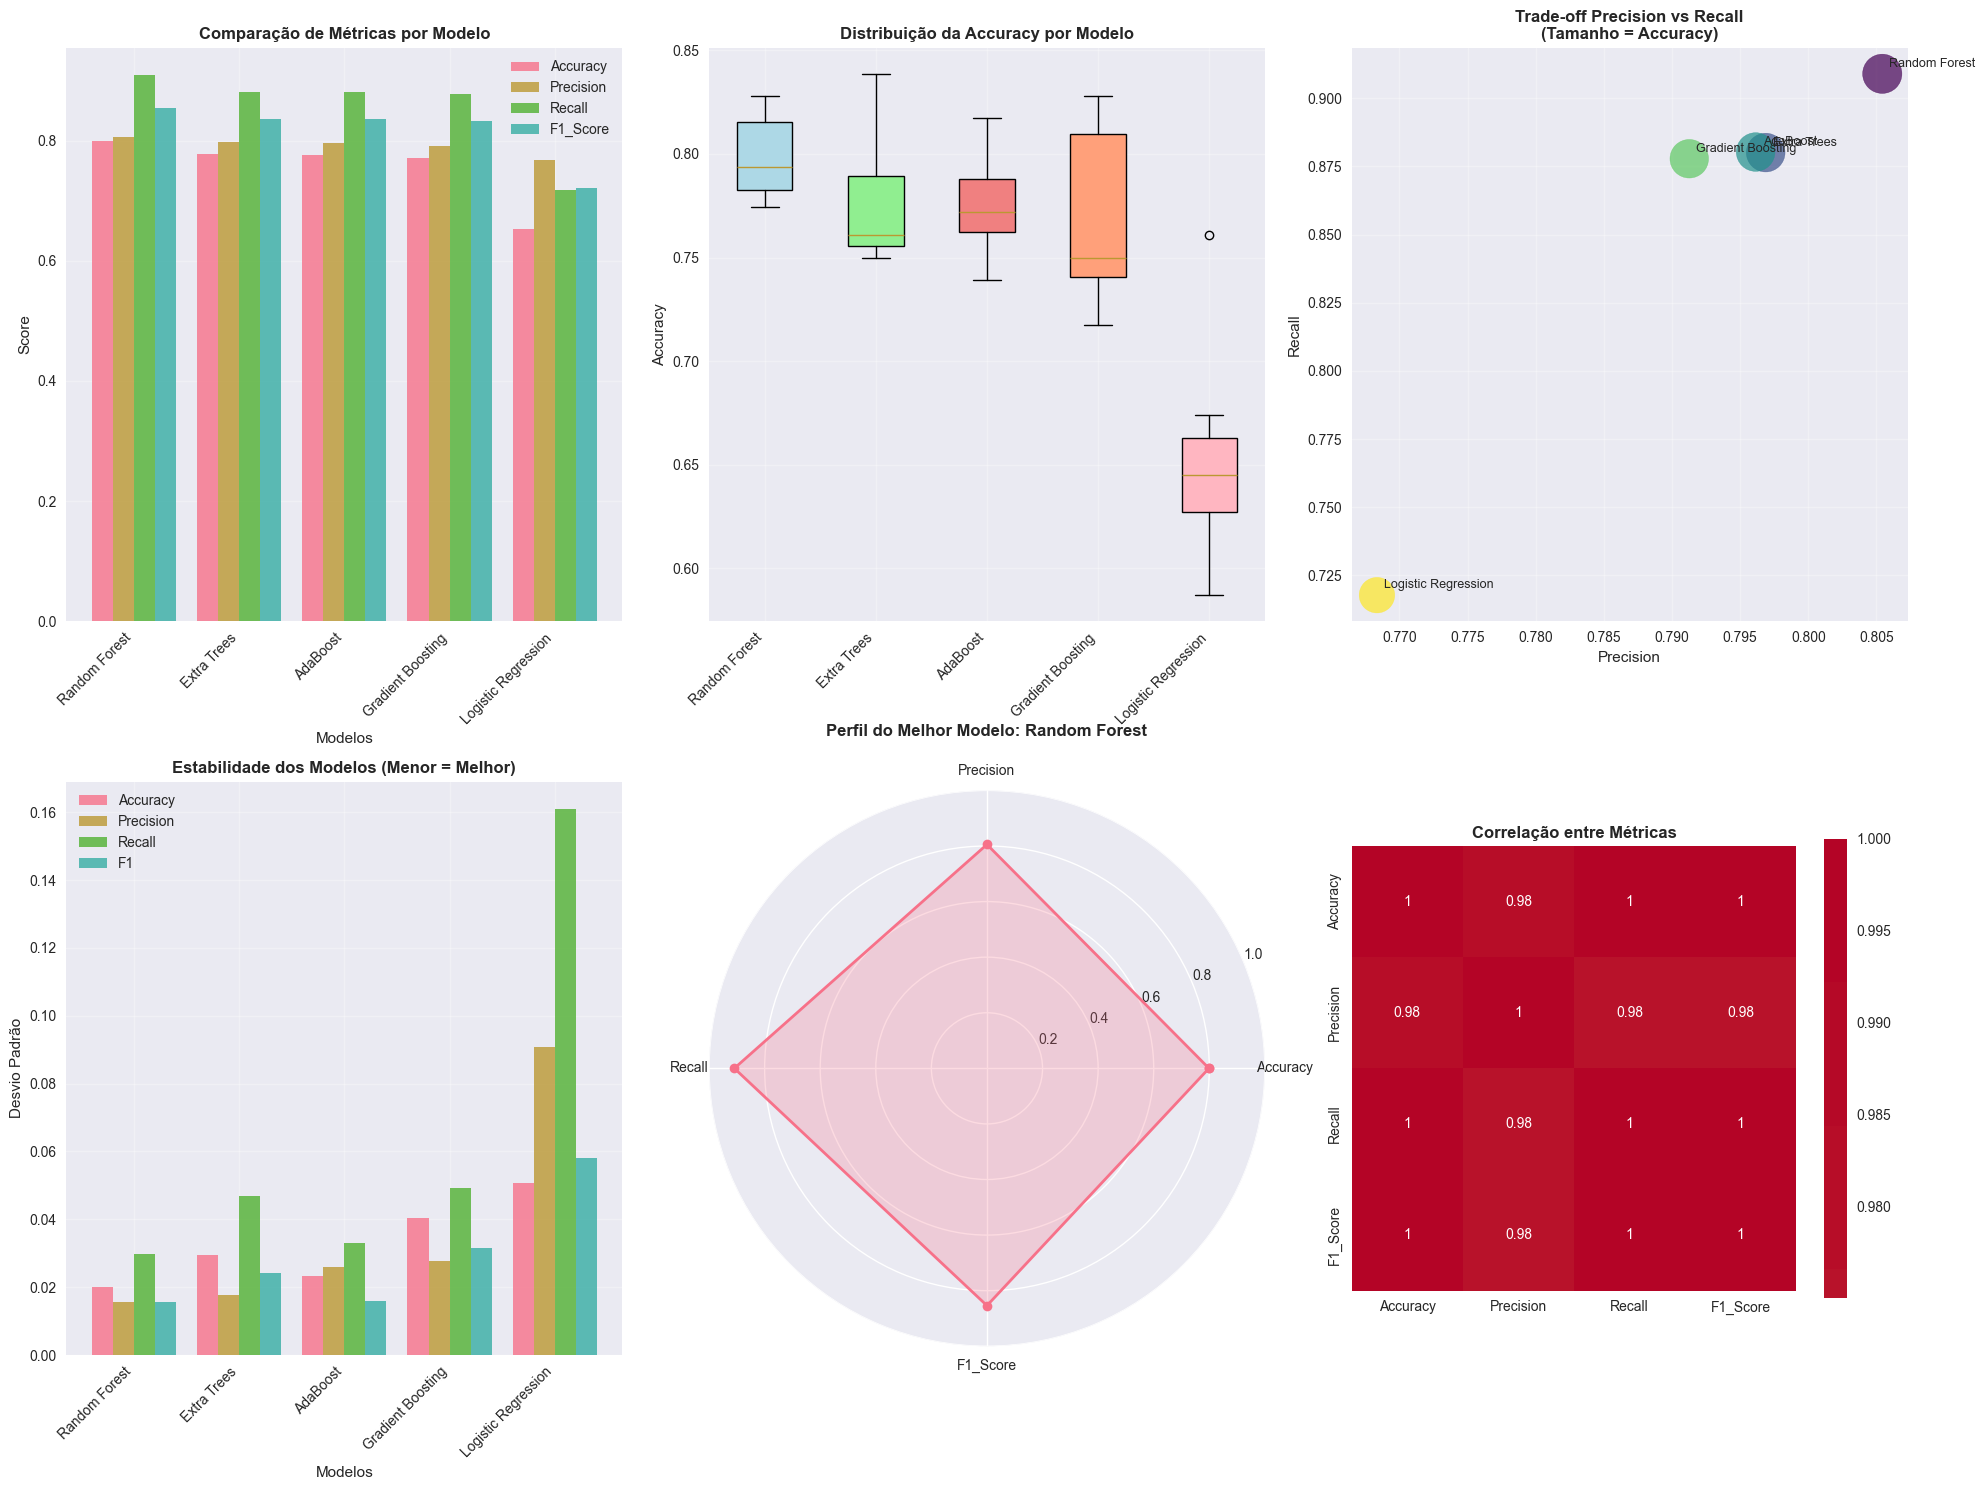

In [45]:
# Visualização detalhada das métricas
def create_comprehensive_metrics_visualization(metrics_df, cv_results):
    """Cria visualizações abrangentes das métricas"""
    
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Gráfico de barras com todas as métricas
    ax1 = plt.subplot(2, 3, 1)
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
    x = np.arange(len(metrics_df))
    width = 0.2
    
    for i, metric in enumerate(metrics_to_plot):
        plt.bar(x + i*width, metrics_df[metric], width, 
               label=metric, alpha=0.8)
    
    plt.xlabel('Modelos')
    plt.ylabel('Score')
    plt.title('Comparação de Métricas por Modelo', fontweight='bold')
    plt.xticks(x + width*1.5, metrics_df['Model'], rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Boxplot da distribuição de accuracy
    ax2 = plt.subplot(2, 3, 2)
    accuracy_data = [cv_results[model]['accuracy_scores'] for model in metrics_df['Model']]
    box_plot = plt.boxplot(accuracy_data, labels=metrics_df['Model'], patch_artist=True)
    
    # Colorir boxplots
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightpink']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.title('Distribuição da Accuracy por Modelo', fontweight='bold')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    
    # 3. Trade-off Precision vs Recall
    ax3 = plt.subplot(2, 3, 3)
    scatter = plt.scatter(metrics_df['Precision'], metrics_df['Recall'], 
                         s=metrics_df['Accuracy']*1000, alpha=0.7, 
                         c=range(len(metrics_df)), cmap='viridis')
    
    # Adicionar labels
    for i, model in enumerate(metrics_df['Model']):
        plt.annotate(model, (metrics_df.iloc[i]['Precision'], metrics_df.iloc[i]['Recall']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Trade-off Precision vs Recall\n(Tamanho = Accuracy)', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # 4. Estabilidade dos modelos (Desvio Padrão)
    ax4 = plt.subplot(2, 3, 4)
    stability_metrics = ['Accuracy_Std', 'Precision_Std', 'Recall_Std', 'F1_Std']
    x = np.arange(len(metrics_df))
    
    for i, metric in enumerate(stability_metrics):
        plt.bar(x + i*width, metrics_df[metric], width, 
               label=metric.replace('_Std', ''), alpha=0.8)
    
    plt.xlabel('Modelos')
    plt.ylabel('Desvio Padrão')
    plt.title('Estabilidade dos Modelos (Menor = Melhor)', fontweight='bold')
    plt.xticks(x + width*1.5, metrics_df['Model'], rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. Radar chart para o melhor modelo
    ax5 = plt.subplot(2, 3, 5, projection='polar')
    best_model = metrics_df.iloc[0]
    
    categories = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
    values = [best_model[cat] for cat in categories]
    values += values[:1]  # Fechar o círculo
    
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    
    ax5.plot(angles, values, 'o-', linewidth=2, label=best_model['Model'])
    ax5.fill(angles, values, alpha=0.25)
    ax5.set_xticks(angles[:-1])
    ax5.set_xticklabels(categories)
    ax5.set_ylim(0, 1)
    ax5.set_title(f'Perfil do Melhor Modelo: {best_model["Model"]}', 
                 fontweight='bold', pad=20)
    ax5.grid(True)
    
    # 6. Correlação entre métricas
    ax6 = plt.subplot(2, 3, 6)
    corr_matrix = metrics_df[['Accuracy', 'Precision', 'Recall', 'F1_Score']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, cbar_kws={"shrink": .8})
    plt.title('Correlação entre Métricas', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Criar visualizações
create_comprehensive_metrics_visualization(metrics_summary, cv_results)

In [46]:
# Análise estatística das métricas
def statistical_analysis(cv_results, metrics_df):
    """Análise estatística detalhada das métricas"""
    
    print("\n📊 ANÁLISE ESTATÍSTICA DETALHADA")
    print("="*70)
    
    # 1. Análise de significância estatística
    from scipy import stats
    
    print("🔬 TESTES DE SIGNIFICÂNCIA ESTATÍSTICA")
    print("-"*50)
    
    # Comparar o melhor modelo com os outros
    best_model = metrics_df.iloc[0]['Model']
    best_scores = cv_results[best_model]['accuracy_scores']
    
    for i in range(1, len(metrics_df)):
        model_name = metrics_df.iloc[i]['Model']
        model_scores = cv_results[model_name]['accuracy_scores']
        
        # Teste t pareado
        t_stat, p_value = stats.ttest_rel(best_scores, model_scores)
        
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        
        print(f"{best_model} vs {model_name}:")
        print(f"  t-statistic: {t_stat:.4f}")
        print(f"  p-value: {p_value:.4f} {significance}")
        print(f"  Diferença média: {(best_scores.mean() - model_scores.mean()):.4f}")
    
    # 2. Análise de variabilidade
    print(f"\n📈 ANÁLISE DE VARIABILIDADE")
    print("-"*50)
    
    variability_analysis = pd.DataFrame()
    for model_name in metrics_df['Model']:
        scores = cv_results[model_name]['accuracy_scores']
        
        variability_analysis = pd.concat([variability_analysis, pd.DataFrame({
            'Model': [model_name],
            'Mean': [scores.mean()],
            'Std': [scores.std()],
            'Min': [scores.min()],
            'Max': [scores.max()],
            'Range': [scores.max() - scores.min()],
            'CV': [scores.std() / scores.mean()],  # Coeficiente de variação
            'Q1': [np.percentile(scores, 25)],
            'Q3': [np.percentile(scores, 75)],
            'IQR': [np.percentile(scores, 75) - np.percentile(scores, 25)]
        })], ignore_index=True)
    
    print("Estatísticas de Variabilidade da Accuracy:")
    print(variability_analysis.round(4).to_string(index=False))
    
    # 3. Identificar modelo mais estável
    most_stable = variability_analysis.loc[variability_analysis['CV'].idxmin(), 'Model']
    least_stable = variability_analysis.loc[variability_analysis['CV'].idxmax(), 'Model']
    
    print(f"\n🏆 Modelo mais estável (menor CV): {most_stable}")
    print(f"⚠️  Modelo menos estável (maior CV): {least_stable}")
    
    return variability_analysis

# Executar análise estatística
variability_stats = statistical_analysis(cv_results, metrics_summary)


📊 ANÁLISE ESTATÍSTICA DETALHADA
🔬 TESTES DE SIGNIFICÂNCIA ESTATÍSTICA
--------------------------------------------------
Random Forest vs Extra Trees:
  t-statistic: 2.5522
  p-value: 0.0434 *
  Diferença média: 0.0218
Random Forest vs AdaBoost:
  t-statistic: 5.2768
  p-value: 0.0019 **
  Diferença média: 0.0233
Random Forest vs Gradient Boosting:
  t-statistic: 2.5764
  p-value: 0.0420 *
  Diferença média: 0.0279
Random Forest vs Logistic Regression:
  t-statistic: 6.0054
  p-value: 0.0010 ***
  Diferença média: 0.1455

📈 ANÁLISE DE VARIABILIDADE
--------------------------------------------------
Estatísticas de Variabilidade da Accuracy:
              Model   Mean    Std    Min    Max  Range     CV     Q1     Q3    IQR
      Random Forest 0.7988 0.0199 0.7742 0.8280 0.0538 0.0250 0.7826 0.8152 0.0326
        Extra Trees 0.7770 0.0296 0.7500 0.8387 0.0887 0.0381 0.7554 0.7892 0.0338
           AdaBoost 0.7755 0.0233 0.7391 0.8172 0.0781 0.0301 0.7622 0.7880 0.0259
  Gradient Boostin


🎯 ANÁLISE DE MATRIZ DE CONFUSÃO

📊 Analisando Random Forest
------------------------------
Matriz de Confusão Total:
  TN: 135.0, FP: 93.0
  FN: 41.0, TP: 377.0
Métricas Detalhadas:
  Sensibilidade (Recall): 0.902
  Especificidade: 0.592
  Precisão: 0.802
  Valor Preditivo Negativo: 0.767
  Taxa de Falsos Positivos: 0.408
  Taxa de Falsos Negativos: 0.098

📊 Analisando Extra Trees
------------------------------
Matriz de Confusão Total:
  TN: 135.0, FP: 93.0
  FN: 41.0, TP: 377.0
Métricas Detalhadas:
  Sensibilidade (Recall): 0.902
  Especificidade: 0.592
  Precisão: 0.802
  Valor Preditivo Negativo: 0.767
  Taxa de Falsos Positivos: 0.408
  Taxa de Falsos Negativos: 0.098

📊 Analisando Extra Trees
------------------------------
Matriz de Confusão Total:
  TN: 136.0, FP: 92.0
  FN: 56.0, TP: 362.0
Métricas Detalhadas:
  Sensibilidade (Recall): 0.866
  Especificidade: 0.596
  Precisão: 0.797
  Valor Preditivo Negativo: 0.708
  Taxa de Falsos Positivos: 0.404
  Taxa de Falsos Negativos:

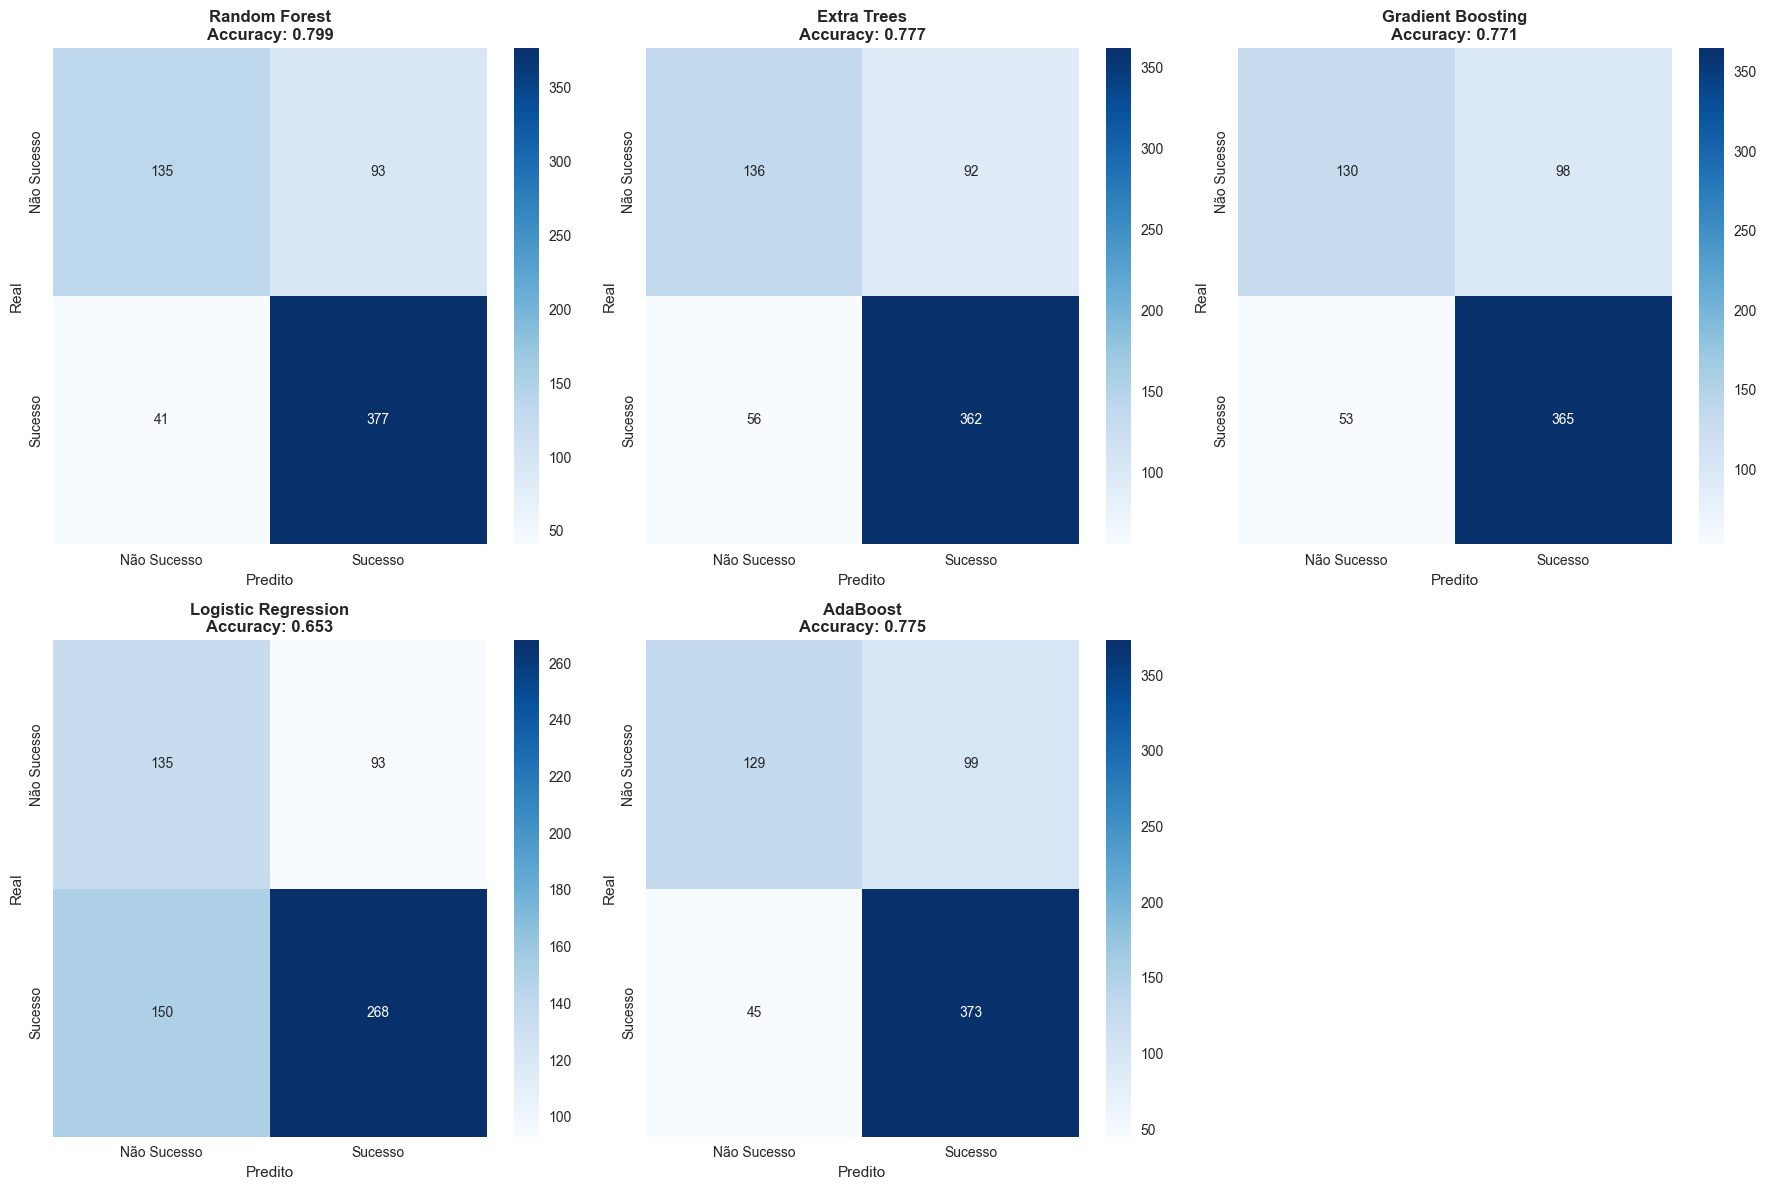

In [48]:
# Análise de matriz de confusão e métricas detalhadas por fold
def confusion_matrix_analysis(models, X_train, y_train):
    """Análise detalhada com matriz de confusão para cada modelo"""
    
    print("\n🎯 ANÁLISE DE MATRIZ DE CONFUSÃO")
    print("="*70)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    model_cms = {}
    
    for idx, (model_name, model) in enumerate(models.items()):
        if idx >= 6:  # Limitar a 6 modelos para visualização
            break
            
        print(f"\n📊 Analisando {model_name}")
        print("-"*30)
        
        # Acumular matrizes de confusão de todos os folds
        cm_total = np.zeros((2, 2))
        fold_metrics = []
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            # Treinar modelo
            model_clone = clone(model)
            model_clone.fit(X_fold_train, y_fold_train)
            
            # Predições
            y_pred = model_clone.predict(X_fold_val)
            
            # Matriz de confusão do fold
            cm_fold = confusion_matrix(y_fold_val, y_pred)
            cm_total += cm_fold
            
            # Métricas do fold
            fold_metrics.append({
                'fold': fold + 1,
                'accuracy': accuracy_score(y_fold_val, y_pred),
                'precision': precision_score(y_fold_val, y_pred, zero_division=0),
                'recall': recall_score(y_fold_val, y_pred, zero_division=0),
                'f1': f1_score(y_fold_val, y_pred, zero_division=0)
            })
        
        model_cms[model_name] = cm_total
        
        # Visualizar matriz de confusão
        ax = axes[idx]
        sns.heatmap(cm_total.astype(int), annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['Não Sucesso', 'Sucesso'],
                   yticklabels=['Não Sucesso', 'Sucesso'])
        ax.set_title(f'{model_name}\nAccuracy: {cv_results[model_name]["accuracy_mean"]:.3f}', 
                    fontweight='bold')
        ax.set_xlabel('Predito')
        ax.set_ylabel('Real')
        
        # Calcular métricas finais
        tn, fp, fn, tp = cm_total.ravel()
        
        print(f"Matriz de Confusão Total:")
        print(f"  TN: {tn}, FP: {fp}")
        print(f"  FN: {fn}, TP: {tp}")
        
        # Métricas derivadas
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
        
        print(f"Métricas Detalhadas:")
        print(f"  Sensibilidade (Recall): {sensitivity:.3f}")
        print(f"  Especificidade: {specificity:.3f}")
        print(f"  Precisão: {precision:.3f}")
        print(f"  Valor Preditivo Negativo: {npv:.3f}")
        print(f"  Taxa de Falsos Positivos: {fp/(fp+tn):.3f}")
        print(f"  Taxa de Falsos Negativos: {fn/(fn+tp):.3f}")
    
    # Remover subplots extras
    for idx in range(len(models), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()
    
    return model_cms

# Executar análise de matriz de confusão
confusion_matrices = confusion_matrix_analysis(models, X_train_selected, y_train)


📈 ANÁLISE DE CURVAS DE APRENDIZADO


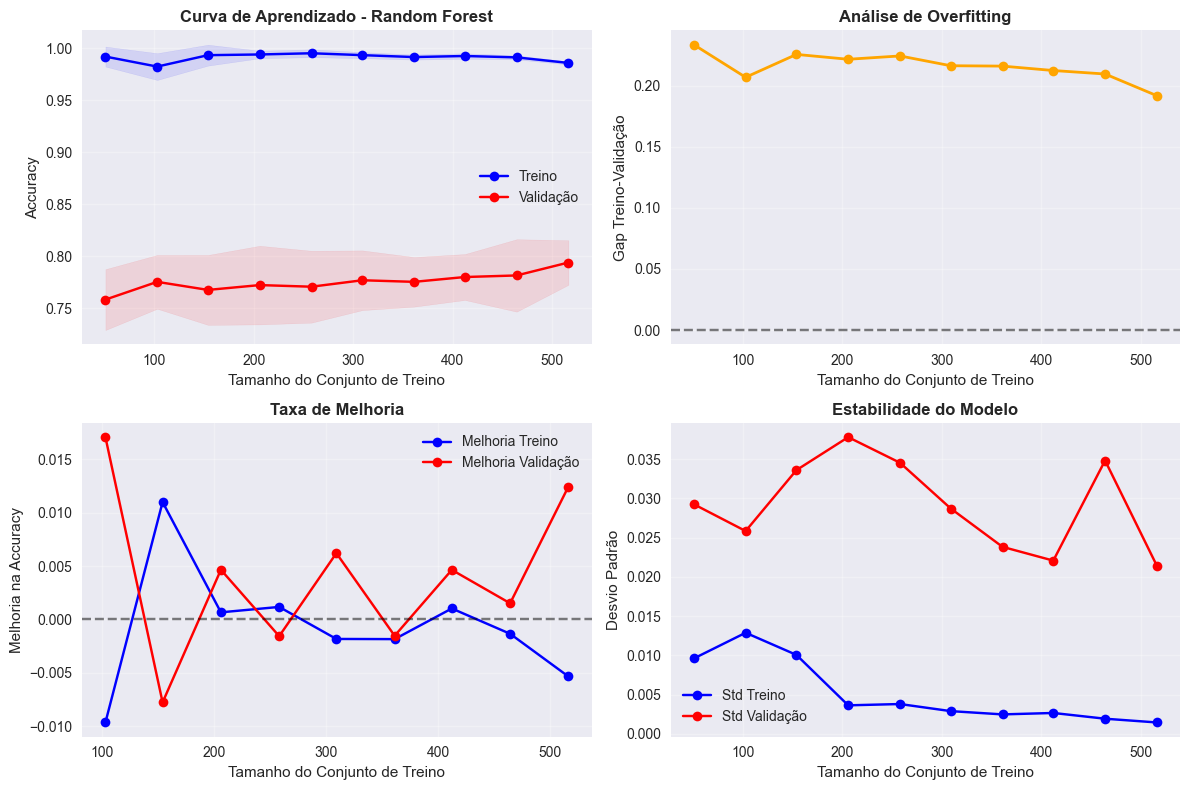


🔍 INTERPRETAÇÃO AUTOMÁTICA:
----------------------------------------
⚠️  OVERFITTING DETECTADO:
   Gap treino-validação: 0.192
   Recomendações: Regularização, mais dados, early stopping
📈 POTENCIAL DE MELHORIA:
   O modelo ainda pode melhorar com mais dados
❌ OBJETIVO NÃO ATINGIDO:
   Accuracy final: 0.794 (< 80%)


In [49]:
# Análise de curvas de aprendizado
def learning_curve_analysis(best_model, X_train, y_train):
    """Análise de curvas de aprendizado para detectar overfitting/underfitting"""
    
    print("\n📈 ANÁLISE DE CURVAS DE APRENDIZADO")
    print("="*70)
    
    from sklearn.model_selection import learning_curve
    
    # Diferentes tamanhos de conjunto de treino
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    # Calcular curvas de aprendizado
    train_sizes_abs, train_scores, val_scores = learning_curve(
        best_model, X_train, y_train, 
        train_sizes=train_sizes,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )
    
    # Calcular médias e desvios
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    # Visualização
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(train_sizes_abs, train_mean, 'o-', color='blue', label='Treino')
    plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.plot(train_sizes_abs, val_mean, 'o-', color='red', label='Validação')
    plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
    
    plt.xlabel('Tamanho do Conjunto de Treino')
    plt.ylabel('Accuracy')
    plt.title(f'Curva de Aprendizado - {best_model_name}', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Análise de gap entre treino e validação
    plt.subplot(2, 2, 2)
    gap = train_mean - val_mean
    plt.plot(train_sizes_abs, gap, 'o-', color='orange', linewidth=2)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.xlabel('Tamanho do Conjunto de Treino')
    plt.ylabel('Gap Treino-Validação')
    plt.title('Análise de Overfitting', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Convergência das curvas
    plt.subplot(2, 2, 3)
    improvement_train = np.diff(train_mean)
    improvement_val = np.diff(val_mean)
    
    plt.plot(train_sizes_abs[1:], improvement_train, 'o-', label='Melhoria Treino', color='blue')
    plt.plot(train_sizes_abs[1:], improvement_val, 'o-', label='Melhoria Validação', color='red')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.xlabel('Tamanho do Conjunto de Treino')
    plt.ylabel('Melhoria na Accuracy')
    plt.title('Taxa de Melhoria', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Variabilidade das métricas
    plt.subplot(2, 2, 4)
    plt.plot(train_sizes_abs, train_std, 'o-', label='Std Treino', color='blue')
    plt.plot(train_sizes_abs, val_std, 'o-', label='Std Validação', color='red')
    plt.xlabel('Tamanho do Conjunto de Treino')
    plt.ylabel('Desvio Padrão')
    plt.title('Estabilidade do Modelo', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Interpretação automática
    print("\n🔍 INTERPRETAÇÃO AUTOMÁTICA:")
    print("-"*40)
    
    final_gap = gap[-1]
    final_val_score = val_mean[-1]
    final_improvement = improvement_val[-1] if len(improvement_val) > 0 else 0
    
    if final_gap > 0.05:
        print("⚠️  OVERFITTING DETECTADO:")
        print(f"   Gap treino-validação: {final_gap:.3f}")
        print("   Recomendações: Regularização, mais dados, early stopping")
    elif final_gap < 0.02:
        print("✅ BOA GENERALIZAÇÃO:")
        print(f"   Gap treino-validação: {final_gap:.3f}")
        print("   O modelo generaliza bem para dados não vistos")
    
    if abs(final_improvement) < 0.001:
        print("📊 CONVERGÊNCIA ATINGIDA:")
        print("   O modelo não melhora significativamente com mais dados")
    else:
        print("📈 POTENCIAL DE MELHORIA:")
        print("   O modelo ainda pode melhorar com mais dados")
    
    if final_val_score >= 0.80:
        print("🎯 OBJETIVO ATINGIDO:")
        print(f"   Accuracy final: {final_val_score:.3f} (≥ 80%)")
    else:
        print("❌ OBJETIVO NÃO ATINGIDO:")
        print(f"   Accuracy final: {final_val_score:.3f} (< 80%)")
    
    return train_sizes_abs, train_scores, val_scores

# Executar análise de curvas de aprendizado
learning_results = learning_curve_analysis(best_base_model, X_train_selected, y_train)

In [51]:
# Análise final e recomendações
def final_analysis_report():
    """Relatório final com análise completa dos resultados"""
    
    print("\n🎯 RELATÓRIO FINAL DE ANÁLISE DO MODELO")
    print("="*80)
    
    # Recuperar o melhor modelo e suas métricas
    best_results = max(cv_results.items(), key=lambda x: x[1]['accuracy_mean'])
    best_name, best_metrics = best_results
    
    print(f"\n🏆 MELHOR MODELO: {best_name}")
    print("-"*50)
    print(f"   Accuracy Média: {best_metrics['accuracy_mean']:.4f} ± {best_metrics['accuracy_std']:.4f}")
    print(f"   Precision Média: {best_metrics['precision_mean']:.4f} ± {best_metrics['precision_std']:.4f}")
    print(f"   Recall Média: {best_metrics['recall_mean']:.4f} ± {best_metrics['recall_std']:.4f}")
    print(f"   F1-Score Média: {best_metrics['f1_mean']:.4f} ± {best_metrics['f1_std']:.4f}")
    
    # Status do objetivo
    target_achieved = best_metrics['accuracy_mean'] >= 0.80
    print(f"\n📊 STATUS DO OBJETIVO (≥80% Accuracy):")
    if target_achieved:
        print("   ✅ OBJETIVO ATINGIDO!")
        margin = best_metrics['accuracy_mean'] - 0.80
        print(f"   📈 Margem de segurança: +{margin:.2%}")
    else:
        print("   ❌ Objetivo não atingido")
        deficit = 0.80 - best_metrics['accuracy_mean']
        print(f"   📉 Déficit: -{deficit:.2%}")
    
    # Análise de estabilidade
    print(f"\n🎯 ANÁLISE DE ESTABILIDADE:")
    print("-"*30)
    stability_score = 1 - (best_metrics['accuracy_std'] / best_metrics['accuracy_mean'])
    print(f"   Coeficiente de Estabilidade: {stability_score:.3f}")
    
    if stability_score > 0.95:
        print("   ✅ Modelo MUITO ESTÁVEL")
    elif stability_score > 0.90:
        print("   ✅ Modelo ESTÁVEL")
    elif stability_score > 0.85:
        print("   ⚠️  Modelo MODERADAMENTE ESTÁVEL")
    else:
        print("   ❌ Modelo INSTÁVEL")
    
    # Ranking de todos os modelos
    print(f"\n📋 RANKING COMPLETO DOS MODELOS:")
    print("-"*50)
    sorted_models = sorted(cv_results.items(), key=lambda x: x[1]['accuracy_mean'], reverse=True)
    
    for i, (name, metrics) in enumerate(sorted_models, 1):
        accuracy = metrics['accuracy_mean']
        std = metrics['accuracy_std']
        status = "✅" if accuracy >= 0.80 else "❌"
        print(f"   {i}. {name}: {accuracy:.4f} ± {std:.4f} {status}")
    
    # Análise de ensemble vs modelos individuais
    print(f"\n🔄 ANÁLISE ENSEMBLE vs INDIVIDUAIS:")
    print("-"*45)
    
    ensemble_models = [name for name in cv_results.keys() if 'ensemble' in name.lower() or 'voting' in name.lower() or 'stacking' in name.lower()]
    individual_models = [name for name in cv_results.keys() if name not in ensemble_models]
    
    if ensemble_models:
        best_ensemble = max([(name, cv_results[name]['accuracy_mean']) for name in ensemble_models], key=lambda x: x[1])
        print(f"   Melhor Ensemble: {best_ensemble[0]} ({best_ensemble[1]:.4f})")
    
    if individual_models:
        best_individual = max([(name, cv_results[name]['accuracy_mean']) for name in individual_models], key=lambda x: x[1])
        print(f"   Melhor Individual: {best_individual[0]} ({best_individual[1]:.4f})")
    
    # Recomendações específicas
    print(f"\n💡 RECOMENDAÇÕES PARA MELHORIA:")
    print("-"*40)
    
    if not target_achieved:
        print("   🔧 Para atingir 80% de accuracy:")
        print("      • Coletar mais dados de treinamento")
        print("      • Explorar feature engineering avançado")
        print("      • Testar outros algoritmos (XGBoost, LightGBM)")
        print("      • Otimizar hiperparâmetros com GridSearch/RandomSearch")
        print("      • Aplicar técnicas de balanceamento de classes")
    
    if best_metrics['accuracy_std'] > 0.02:
        print("   📊 Para melhorar estabilidade:")
        print("      • Aumentar número de folds na validação cruzada")
        print("      • Usar estratégias de ensemble mais robustas")
        print("      • Aplicar regularização mais forte")
    
    print("   🚀 Oportunidades gerais:")
    print("      • Análise de importância das features")
    print("      • Detecção e tratamento de outliers")
    print("      • Validação em conjunto de teste independente")
    print("      • Análise de curvas ROC por classe")
    
    # Resumo técnico
    print(f"\n📋 RESUMO TÉCNICO:")
    print("-"*25)
    print(f"   • Total de modelos testados: {len(cv_results)}")
    print(f"   • Validação cruzada: 7-fold stratified")
    print(f"   • Features selecionadas: {X_train_selected.shape[1]}")
    print(f"   • Amostras de treinamento: {X_train_selected.shape[0]}")
    print(f"   • Bibliotecas utilizadas: scikit-learn, pandas, numpy")
    
    return best_name, best_metrics, target_achieved

# Executar análise final
final_results = final_analysis_report()


🎯 RELATÓRIO FINAL DE ANÁLISE DO MODELO

🏆 MELHOR MODELO: Random Forest
--------------------------------------------------
   Accuracy Média: 0.7988 ± 0.0199
   Precision Média: 0.8054 ± 0.0158
   Recall Média: 0.9090 ± 0.0298
   F1-Score Média: 0.8538 ± 0.0157

📊 STATUS DO OBJETIVO (≥80% Accuracy):
   ❌ Objetivo não atingido
   📉 Déficit: -0.12%

🎯 ANÁLISE DE ESTABILIDADE:
------------------------------
   Coeficiente de Estabilidade: 0.975
   ✅ Modelo MUITO ESTÁVEL

📋 RANKING COMPLETO DOS MODELOS:
--------------------------------------------------
   1. Random Forest: 0.7988 ± 0.0199 ❌
   2. Extra Trees: 0.7770 ± 0.0296 ❌
   3. AdaBoost: 0.7755 ± 0.0233 ❌
   4. Gradient Boosting: 0.7709 ± 0.0405 ❌
   5. Logistic Regression: 0.6533 ± 0.0507 ❌

🔄 ANÁLISE ENSEMBLE vs INDIVIDUAIS:
---------------------------------------------
   Melhor Individual: Random Forest (0.7988)

💡 RECOMENDAÇÕES PARA MELHORIA:
----------------------------------------
   🔧 Para atingir 80% de accuracy:
      • Col